# 0. Import libraries

In [1]:
import numpy as np
import awkward as ak
import pandas as pd
import uproot as up
from scipy.optimize import differential_evolution as de
import yaml
import inspect
from matplotlib import pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import vector
vector.register_awkward()
import warnings
from matplotlib.colors import LogNorm

K = 40000000 * (2750 / 3564)
SCALE = 12

# 1. Utility functions

In [2]:
def getBranch(data, l1jet):
    
    # Get list of branches relating to the given jet
    # print("Getting list of interesting branches")
    interestingBranches = [branch for branch in data.keys() if l1jet in branch and not f"n{l1jet}" in branch]# and not f"{l1jet}_dau0" in branch] 
    
    # Get only branches corresponding to the desired l1jet
    # print("Querying the array with interesting branches")
    l1jetData = data.arrays(interestingBranches)
    
    # Get a dictionary relating default branch names to new branch names (ie without leading ak8PuppiJets_...)
    # print("Splitting branch names on _ to get renamed fields")
    renamedFields = {field : field.split('_', maxsplit=1)[-1] for field in interestingBranches}

    # Create a new awkward array with the desired l1jet branches and the new branch names
    # print("Returning an ak array of the relevant data with the renamed fields")
    arr = ak.Array({renamedFields[field]: l1jetData[field] for field in l1jetData.fields})
    
    array_dict = {key: arr[key] for key in arr.fields}
    quarks4mom = ak.zip(array_dict)
    quarks4mom = ak.with_name(quarks4mom, "Momentum4D")
    
    return quarks4mom

# 2. Seeds class

In [3]:
class L1_SinglePFJet8:
    """ SELECTION ON LEADING JET PT """
    def __init__(self, pt_threshold=126.5):
        self.pt_threshold = pt_threshold

    def __call__(self, sc8):
        leading = ak.firsts(sc8)
        mask = ak.ones_like(leading.pt, dtype=bool)
        mask = mask & (leading.pt > self.pt_threshold)
        return mask


class L1_SinglePFJet8_Mass:
    """ SELECTION ON LEADING JET PT AND MASS """
    def __init__(self, pt_threshold, mass_threshold):
        self.pt_threshold = pt_threshold
        self.mass_threshold = mass_threshold

    def __call__(self, sc8):
        leading = ak.firsts(sc8)
        mask = ak.ones_like(leading.pt, dtype=bool)
        mask = mask & (leading.pt > self.pt_threshold)
        mask = mask & (leading.mass > self.mass_threshold)
        return mask


class L1_DoublePFJet8_dEtaMax:
    """ SELECTION ON LEADING AND SUBLEADING JET PT, WITH ETA REQUIREMENT """
    def __init__(self, pt_thresholdA, pt_thresholdB, separation=1.6):
        self.pt_thresholdA = pt_thresholdA
        self.pt_thresholdB = pt_thresholdB
        self.separation = separation

    def __call__(self, sc8):
        leading = ak.firsts(sc8)
        subleading = ak.firsts(sc8[:, 1:])
        mask = ak.ones_like(leading.pt, dtype=bool)
        mask = mask & (abs(leading.eta - subleading.eta) < self.separation)
        mask = mask & (leading.pt > self.pt_thresholdA)
        mask = mask & (subleading.pt > self.pt_thresholdB)
        return mask


class L1_DoublePFJet8_dEtaMax_Mass:
    """ SELECTION ON LEADING AND SUBLEADING JET PT AND MASS, WITH ETA REQUIREMENT """
    def __init__(self, pt_thresholdA, mass_thresholdA, pt_thresholdB, mass_thresholdB, separation=1.6):
        self.pt_thresholdA = pt_thresholdA
        self.mass_thresholdA = mass_thresholdA
        self.pt_thresholdB = pt_thresholdB
        self.mass_thresholdB = mass_thresholdB
        self.separation = separation

    def __call__(self, sc8):
        leading = ak.firsts(sc8)
        subleading = ak.firsts(sc8[:, 1:])
        mask = ak.ones_like(leading.pt, dtype=bool)
        mask = mask & (abs(leading.eta - subleading.eta) < self.separation)
        mask = mask & (leading.pt > self.pt_thresholdA)
        mask = mask & (leading.mass > self.mass_thresholdA)
        mask = mask & (subleading.pt > self.pt_thresholdB)
        mask = mask & (subleading.mass > self.mass_thresholdB)
        return mask
    

class L1_DoublePFJet8_dEtaMax_Sum_Mass:
    """ SELECTION ON LEADING AND SUBLEADING JET PT, WITH A REQUIREMENT ON SUM OF THEIR MASSES, AND ETA SEPARATION REQUIREMENT """
    def __init__(self, pt_thresholdA, pt_thresholdB, mass_sum_threshold, separation=1.6):
        self.pt_thresholdA = pt_thresholdA
        self.pt_thresholdB = pt_thresholdB
        self.mass_sum_threshold = mass_sum_threshold
        self.separation = separation

    def __call__(self, sc8):
        leading = ak.firsts(sc8)
        subleading = ak.firsts(sc8[:, 1:])
        mask = ak.ones_like(leading.pt, dtype=bool)
        mask = mask & ( abs(leading.eta - subleading.eta) < self.separation )
        mask = mask & (leading.pt > self.pt_thresholdA)
        mask = mask & (subleading.pt > self.pt_thresholdB)
        mask = mask & ( (leading.mass + subleading.mass) > self.mass_sum_threshold )
        return mask


class L1_DoublePFJet8_Sum:
    def __init__(self, pt_sum_threshold=201):
        self.pt_sum_threshold = pt_sum_threshold

    def __call__(self, sc8):
        leading = ak.firsts(sc8)
        subleading = ak.firsts(sc8[:, 1:])
        mask = ak.ones_like(leading.pt, dtype=bool)
        mask = mask & ((leading.pt + subleading.pt) > self.pt_sum_threshold)
        return mask


class L1_DoublePFJet8_Sum_Mass:
    def __init__(self, pt_sum_threshold, mass_sum_threshold):
        self.pt_sum_threshold = pt_sum_threshold
        self.mass_sum_threshold = mass_sum_threshold

    def __call__(self, sc8):
        leading = ak.firsts(sc8)
        subleading = ak.firsts(sc8[:, 1:])
        mask = ak.ones_like(leading.pt, dtype=bool)
        mask = mask & ((leading.pt + subleading.pt) > self.pt_sum_threshold)
        mask = mask & ((leading.mass + subleading.mass) > self.mass_sum_threshold)
        return mask


class L1_DoublePFJet8_Sum_dEtaMax:
    def __init__(self, pt_sum_threshold=180, separation=1.6):
        self.pt_sum_threshold = pt_sum_threshold
        self.separation = separation

    def __call__(self, sc8):
        leading = ak.firsts(sc8)
        subleading = ak.firsts(sc8[:, 1:])
        mask = ak.ones_like(leading.pt, dtype=bool)
        mask = mask & ((leading.pt + subleading.pt) > self.pt_sum_threshold)
        mask = mask & (abs(leading.eta - subleading.eta) < self.separation)
        return mask


class L1_DoublePFJet8_Sum_dEtaMax_Mass:
    def __init__(self, pt_sum_threshold, mass_sum_threshold, separation=1.6):
        self.pt_sum_threshold = pt_sum_threshold
        self.mass_sum_threshold = mass_sum_threshold
        self.separation = separation

    def __call__(self, sc8):
        leading = ak.firsts(sc8)
        subleading = ak.firsts(sc8[:, 1:])
        mask = ak.ones_like(leading.pt, dtype=bool)
        mask = mask & ((leading.pt + subleading.pt) > self.pt_sum_threshold)
        mask = mask & ((leading.mass + subleading.mass) > self.mass_sum_threshold)
        mask = mask & (abs(leading.eta - subleading.eta) < self.separation)
        return mask
    
# class L1_DoublePFJet8:
#     def __init__(self, pt_thresholdA, pt_thresholdB, separation=1.6):
#         self.pt_thresholdA = pt_thresholdA
#         self.pt_thresholdB = pt_thresholdB
#         self.separation = separation

#     def __call__(self, sc8):
#         leading = ak.firsts(sc8)
#         subleading = ak.firsts(sc8[:, 1:])
#         mask = ak.ones_like(leading.pt, dtype=bool)
#         mask = mask & (leading.pt > self.pt_thresholdA)
#         mask = mask & (subleading.pt > self.thresholdB)
#         mask = mask & (abs(leading.eta - subleading.eta) < self.separation)
#         return mask

# 3. Sample class

In [4]:
class Sample:
    def __init__(self, path_data, path_decisions, exclude=None):
        self.path_data = path_data
        self.path_decisions = path_decisions

        print(f"Loading sample from {path_data} with decisions from {path_decisions}")
        self.decisions = self.load_decisions(exclude)
        self.sc8 = self.load_sc8()
        self.sc4_separated = self.load_sc4_separated(N=1)

        self._validate_lengths()

    def _validate_lengths(self):
        if (len(self.sc8) != len(self.decisions)) | (len(self.sc4_separated) != len(self.decisions)):
            warnings.warn("WARNING: Mismatch! Number of events in jet data does not match number of events in decisions data.")

    def load_decisions(self, exclude=[]) -> pd.DataFrame:
        print(f"    Loading trigger decision bits...")
        decisions = pd.read_parquet(self.path_decisions, engine="fastparquet").astype(bool)
        triggers_to_load = list(decisions.columns.difference(exclude))
        decisions = decisions[triggers_to_load]
        return decisions
    
    def load_sc8(self) -> ak.Array:
        print("    Loading SC8 jets...")
        with up.open(self.path_data + ":Events") as data:
            sc8 = getBranch(data, "L1puppiJetSC8_")
        return sc8

    def load_sc4_separated(self, N=1) -> ak.Array:
        print("    Loading SC4 jets separated from leading SC8 jet...")
        with up.open(self.path_data + ":Events") as data:
            sc4 = getBranch(data, "L1puppiJetSC4_")
        return self._get_sc4_separated(sc4, N)
        
    def _get_sc4_separated(self, sc4, N=1) -> ak.Array:
        a, b = ak.unzip( ak.cartesian([sc4, self.sc8[:,:N]], nested=True) )
        dists_bool = a.deltaR(b) < 0.8
        return sc4[~ak.any(dists_bool, axis=-1)]

In [5]:
class Signal(Sample):
    def __init__(self, path_data, path_decisions, exclude=[]):
        super().__init__(path_data, path_decisions, exclude)
        print(f"    Signal sample with {len(self.decisions)} events")

    def define_triggers(self, trigger, **thresholds):
        setattr(self, trigger.__name__, trigger(**thresholds))

    def get_efficiency(self, mask=None, seed=None):
        if mask is None and seed is None:
            raise ValueError("Either mask or seed must be provided.")
        elif mask is None and seed is not None:
            mask = seed(self.sc8)
        elif mask is not None and seed is None:
            pass
        else:
            raise ValueError("Both mask and seed provided! Provide only one.")
        
        already_passed = ak.Array(self.decisions.any(axis=1).values)  # keep everything in awkward
        # eff = ak.sum(mask) / len(self.decisions)
        total_eff = ak.sum(already_passed | mask) / len(self.decisions)
        pure_eff = total_eff - (ak.sum(already_passed) / len(self.decisions))
        return total_eff, pure_eff

class Background(Sample):
    def __init__(self, path_data, path_decisions, exclude=[]):
        super().__init__(path_data, path_decisions, exclude)
        print(f"    Background sample with {len(self.decisions)} events")

    def get_rate(self, mask):
        rate = K * ak.sum( mask ) / len(mask)
        if isinstance(self.decisions, pd.core.frame.DataFrame):
            already_passed = self.decisions.any(axis=1).values
            not_passed_mask = mask[~already_passed]
            return rate, K * ak.sum( not_passed_mask ) / len(self.decisions)
        else:
            return rate

# 4. Load data

In [6]:
exclude = ["L1_SinglePfJet8_230"]

In [7]:
path_mb_decisions = "/eos/user/l/lroberts/Phase2-L1MenuTools/outputs/V49nano_AR25/rate_tables/MinBias_RateTable_V49nano_AR25_masks.parquet"
path_mb = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/roward/phase2/menu/ntuples/Spring24/151X_AllAR25_FindOn/v45/MinBias_TuneCP5_14TeV-pythia8/MinBias_Spring24_200PUALCA_V45_reL1wTT_151X_AllAR25_FindOn/250615_160052/hadd/output_Phase2_L1T.root"
bkg = Background(path_mb, path_mb_decisions, exclude=exclude)

Loading sample from /eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/roward/phase2/menu/ntuples/Spring24/151X_AllAR25_FindOn/v45/MinBias_TuneCP5_14TeV-pythia8/MinBias_Spring24_200PUALCA_V45_reL1wTT_151X_AllAR25_FindOn/250615_160052/hadd/output_Phase2_L1T.root with decisions from /eos/user/l/lroberts/Phase2-L1MenuTools/outputs/V49nano_AR25/rate_tables/MinBias_RateTable_V49nano_AR25_masks.parquet
    Loading trigger decision bits...
    Loading SC8 jets...
    Loading SC4 jets separated from leading SC8 jet...
    Background sample with 1971360 events


In [8]:
def dataloader(paths, exclude=None):
    with open(paths, "r") as f:
        paths = yaml.safe_load(f)
    return {sample: Signal(paths[sample]["path_data"], paths[sample]["path_decisions"], exclude=exclude) for sample in paths.keys()}

In [9]:
sig = dataloader("./paths.yaml", exclude=exclude)

Loading sample from /eos/user/l/lroberts/Phase2-L1MenuTools/signal_samples/XtoHH_MX-350_MH-50_qq_PU200_signal.root with decisions from /eos/user/l/lroberts/Phase2-L1MenuTools/outputs/V49nano_AR25/rate_tables/MX_350_LH_50_qq_RateTable_V49nano_AR25_masks.parquet
    Loading trigger decision bits...
    Loading SC8 jets...
    Loading SC4 jets separated from leading SC8 jet...
    Signal sample with 4878 events
Loading sample from /eos/user/l/lroberts/Phase2-L1MenuTools/signal_samples/XtoHH_MH-20_qq_PU200_signal.root with decisions from /eos/user/l/lroberts/Phase2-L1MenuTools/outputs/V49nano_AR25/rate_tables/LH_20_qq_RateTable_V49nano_AR25_masks.parquet
    Loading trigger decision bits...
    Loading SC8 jets...
    Loading SC4 jets separated from leading SC8 jet...
    Signal sample with 3147 events
Loading sample from /eos/user/l/lroberts/Phase2-L1MenuTools/signal_samples/XtoHH_MH-30_qq_PU200_signal.root with decisions from /eos/user/l/lroberts/Phase2-L1MenuTools/outputs/V49nano_AR25/r

In [10]:
sig["LH30"].sc8

<MomentumArray4D [[{et: 92.9, eta: ..., ...}, ...], ...] type='2736 * var *...'>

In [11]:
sig["LH20"].define_triggers(L1_SinglePFJet8, pt_threshold=126.5)
sig["LH20"].define_triggers(L1_SinglePFJet8_Mass, pt_threshold=120.7, mass_threshold=17.37)
sig["LH20"].define_triggers(L1_DoublePFJet8_dEtaMax, pt_thresholdA=82.78, pt_thresholdB=74.44, separation=1.6)
sig["LH20"].define_triggers(L1_DoublePFJet8_dEtaMax_Mass, pt_thresholdA=71.96, mass_thresholdA=15.60, pt_thresholdB=60.04, mass_thresholdB=12.91, separation=1.6)
sig["LH20"].define_triggers(L1_DoublePFJet8_dEtaMax_Sum_Mass, pt_thresholdA=73.95, pt_thresholdB=68.35, mass_sum_threshold=30.99, separation=1.6)
sig["LH20"].define_triggers(L1_DoublePFJet8_Sum, pt_sum_threshold=201.0)
sig["LH20"].define_triggers(L1_DoublePFJet8_Sum_Mass, pt_sum_threshold=177.8, mass_sum_threshold=34.01)
sig["LH20"].define_triggers(L1_DoublePFJet8_Sum_dEtaMax, pt_sum_threshold=180.0, separation=1.6)
sig["LH20"].define_triggers(L1_DoublePFJet8_Sum_dEtaMax_Mass, pt_sum_threshold=166.1, mass_sum_threshold=30.92, separation=1.6)

In [12]:
sig["LH30"].define_triggers(L1_SinglePFJet8, pt_threshold=126.5)
sig["LH30"].define_triggers(L1_SinglePFJet8_Mass, pt_threshold=117.1, mass_threshold=20.45)
sig["LH30"].define_triggers(L1_DoublePFJet8_dEtaMax, pt_thresholdA=86.74, pt_thresholdB=73.17, separation=1.6)
sig["LH30"].define_triggers(L1_DoublePFJet8_dEtaMax_Mass, pt_thresholdA=83.06, mass_thresholdA=17.49, pt_thresholdB=55.29, mass_thresholdB=10.41, separation=1.6)
sig["LH30"].define_triggers(L1_DoublePFJet8_dEtaMax_Sum_Mass, pt_thresholdA=81.66, pt_thresholdB=48.48, mass_sum_threshold=35.90, separation=1.6)
sig["LH30"].define_triggers(L1_DoublePFJet8_Sum, pt_sum_threshold=201.0)
sig["LH30"].define_triggers(L1_DoublePFJet8_Sum_Mass, pt_sum_threshold=168.1, mass_sum_threshold=37.23)
sig["LH30"].define_triggers(L1_DoublePFJet8_Sum_dEtaMax, pt_sum_threshold=180.0, separation=1.6)
sig["LH30"].define_triggers(L1_DoublePFJet8_Sum_dEtaMax_Mass, pt_sum_threshold=157.2, mass_sum_threshold=34.11, separation=1.6)

In [13]:
sig["LH40"].define_triggers(L1_SinglePFJet8, pt_threshold=126.5)
sig["LH40"].define_triggers(L1_SinglePFJet8_Mass, pt_threshold=107.0, mass_threshold=25.36)
sig["LH40"].define_triggers(L1_DoublePFJet8_dEtaMax, pt_thresholdA=82.11, pt_thresholdB=74.86, separation=1.6)
sig["LH40"].define_triggers(L1_DoublePFJet8_dEtaMax_Mass, pt_thresholdA=69.5, mass_thresholdA=2.052, pt_thresholdB=74.67, mass_thresholdB=1.361, separation=1.6)
sig["LH40"].define_triggers(L1_DoublePFJet8_dEtaMax_Sum_Mass, pt_thresholdA=77.12, pt_thresholdB=51.66, mass_sum_threshold=36.17, separation=1.6)
sig["LH40"].define_triggers(L1_DoublePFJet8_Sum, pt_sum_threshold=201.0)
sig["LH40"].define_triggers(L1_DoublePFJet8_Sum_Mass, pt_sum_threshold=163.6, mass_sum_threshold=38.20)
sig["LH40"].define_triggers(L1_DoublePFJet8_Sum_dEtaMax, pt_sum_threshold=180.0, separation=1.6)
sig["LH40"].define_triggers(L1_DoublePFJet8_Sum_dEtaMax_Mass, pt_sum_threshold=164.9, mass_sum_threshold=31.59, separation=1.6)

In [14]:
for samp in ["LH50", "LH60", "LH70", "LH80", "LH90", "MX350_LH50"]:
    sig[samp].define_triggers(L1_SinglePFJet8, pt_threshold=126.5)
    sig[samp].define_triggers(L1_SinglePFJet8_Mass, pt_threshold=93.64, mass_threshold=28.42)
    sig[samp].define_triggers(L1_DoublePFJet8_dEtaMax, pt_thresholdA=104.6, pt_thresholdB=62.24, separation=1.6)
    sig[samp].define_triggers(L1_DoublePFJet8_dEtaMax_Mass, pt_thresholdA=92.50, mass_thresholdA=15.97, pt_thresholdB=60.00, mass_thresholdB=5.0, separation=1.6)
    sig[samp].define_triggers(L1_DoublePFJet8_dEtaMax_Sum_Mass, pt_thresholdA=92.01, pt_thresholdB=41.96, mass_sum_threshold=34.57, separation=1.6)
    sig[samp].define_triggers(L1_DoublePFJet8_Sum, pt_sum_threshold=201.0)
    sig[samp].define_triggers(L1_DoublePFJet8_Sum_Mass, pt_sum_threshold=179.4, mass_sum_threshold=33.56)
    sig[samp].define_triggers(L1_DoublePFJet8_Sum_dEtaMax, pt_sum_threshold=180.0, separation=1.6)
    sig[samp].define_triggers(L1_DoublePFJet8_Sum_dEtaMax_Mass, pt_sum_threshold=179.6, mass_sum_threshold=6.542, separation=1.6)

# 5. Plots

In [15]:
def append_rates(sig, bkg, triggers):
    baseline_menu = K * (bkg.decisions.sum(axis=0) / bkg.decisions.count(axis=0))
    for t in triggers:
        trig = getattr(sig, t)
        mask = trig(bkg.sc8)
        rate = bkg.get_rate(mask)[0]
        baseline_menu[t] = rate

    return baseline_menu

In [16]:
label_map = {
    "L1_SinglePFJet8": "Single SC8, $p_T$-only",
    "L1_SinglePFJet8_Mass": "Single SC8, $p_T$ and mass",
    "L1_DoublePFJet8_dEtaMax": "Double SC8 ($\Delta\eta < 1.6$), $p_T$ only",
    "L1_DoublePFJet8_dEtaMax_Mass": "Double SC8 ($\Delta\eta < 1.6$), $p_T$ and mass",
    "L1_DoublePFJet8_dEtaMax_Sum_Mass": "Double SC8 ($\Delta\eta < 1.6$), $p_T$ and sum of masses",
    "L1_DoublePFJet8_Sum": "Double SC8, sum of $p_T$ only",
    "L1_DoublePFJet8_Sum_Mass": "Double SC8, sum of $p_T$ and mass",
    "L1_DoublePFJet8_Sum_dEtaMax": "Double SC8 ($\Delta\eta < 1.6$), sum of $p_T$ only",
    "L1_DoublePFJet8_Sum_dEtaMax_Mass": "Double SC8 ($\Delta\eta < 1.6$), sum of $p_T$ and sum of mass"
}

relevant_seeds = ["L1_DoublePFJet_MassMin", "L1_DoublePFJet_dEtaMax", "L1_PFHTT", "L1_PFHTT_QuadJet", "L1_PFMHTT", "L1_PFMet", "L1_SinglePfJet"]
triggers = ["L1_SinglePFJet8", "L1_SinglePFJet8_Mass", "L1_DoublePFJet8_dEtaMax", "L1_DoublePFJet8_dEtaMax_Mass", "L1_DoublePFJet8_dEtaMax_Sum_Mass",
            "L1_DoublePFJet8_Sum", "L1_DoublePFJet8_Sum_Mass", "L1_DoublePFJet8_Sum_dEtaMax", "L1_DoublePFJet8_Sum_dEtaMax_Mass"] 

formatting = {
    "triggers": triggers+relevant_seeds,
    "highlight": triggers,
    "label_map": label_map
}

def plot_rates(rate_dict: pd.Series, formatting: dict):
    triggers = formatting["triggers"]
    highlight = formatting["highlight"]
    label_map = formatting["label_map"]

    # Subset and sort
    rates_to_plot = rate_dict[triggers]
    sorted_rates = rates_to_plot.sort_values(ascending=True)

    # Map labels for y-axis
    y_labels = [label_map.get(t, t) for t in sorted_rates.index]

    # Colors: orange if in highlight, else blue
    colors = ["tab:orange" if t in highlight else "tab:blue" for t in sorted_rates.index]

    # Plot
    SCALE = len(sorted_rates.index)
    plt.figure(figsize=(SCALE*2, SCALE), facecolor="white")
    plt.barh(y_labels, sorted_rates.values / 1000, color=colors)
    plt.ylim([-1, SCALE])
    plt.yticks(fontsize=SCALE*2)
    plt.xticks(np.linspace(0, 90, 10), fontsize=SCALE*2)
    plt.xlabel("Minbias rate (kHz)", fontsize=SCALE*3)
    plt.grid()

    # Add legend handles manually for the two categories
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="tab:orange", label="\nPotential new wide cone jet triggers, each contributing\n10 kHz of pure rate to the Phase-2 L1T menu\n"),
        Patch(facecolor="tab:blue", label="\nExisting seeds in Phase-2 L1T efficient\nfor boosted hadronic decays\n"),
    ]
    plt.legend(handles=legend_elements, loc="lower right", fontsize=SCALE*2)

    hep.cms.label(llabel="Phase-2 Simulation Preliminary", rlabel="14 TeV", fontsize=SCALE*3)
    plt.tight_layout()
    plt.show()

    return


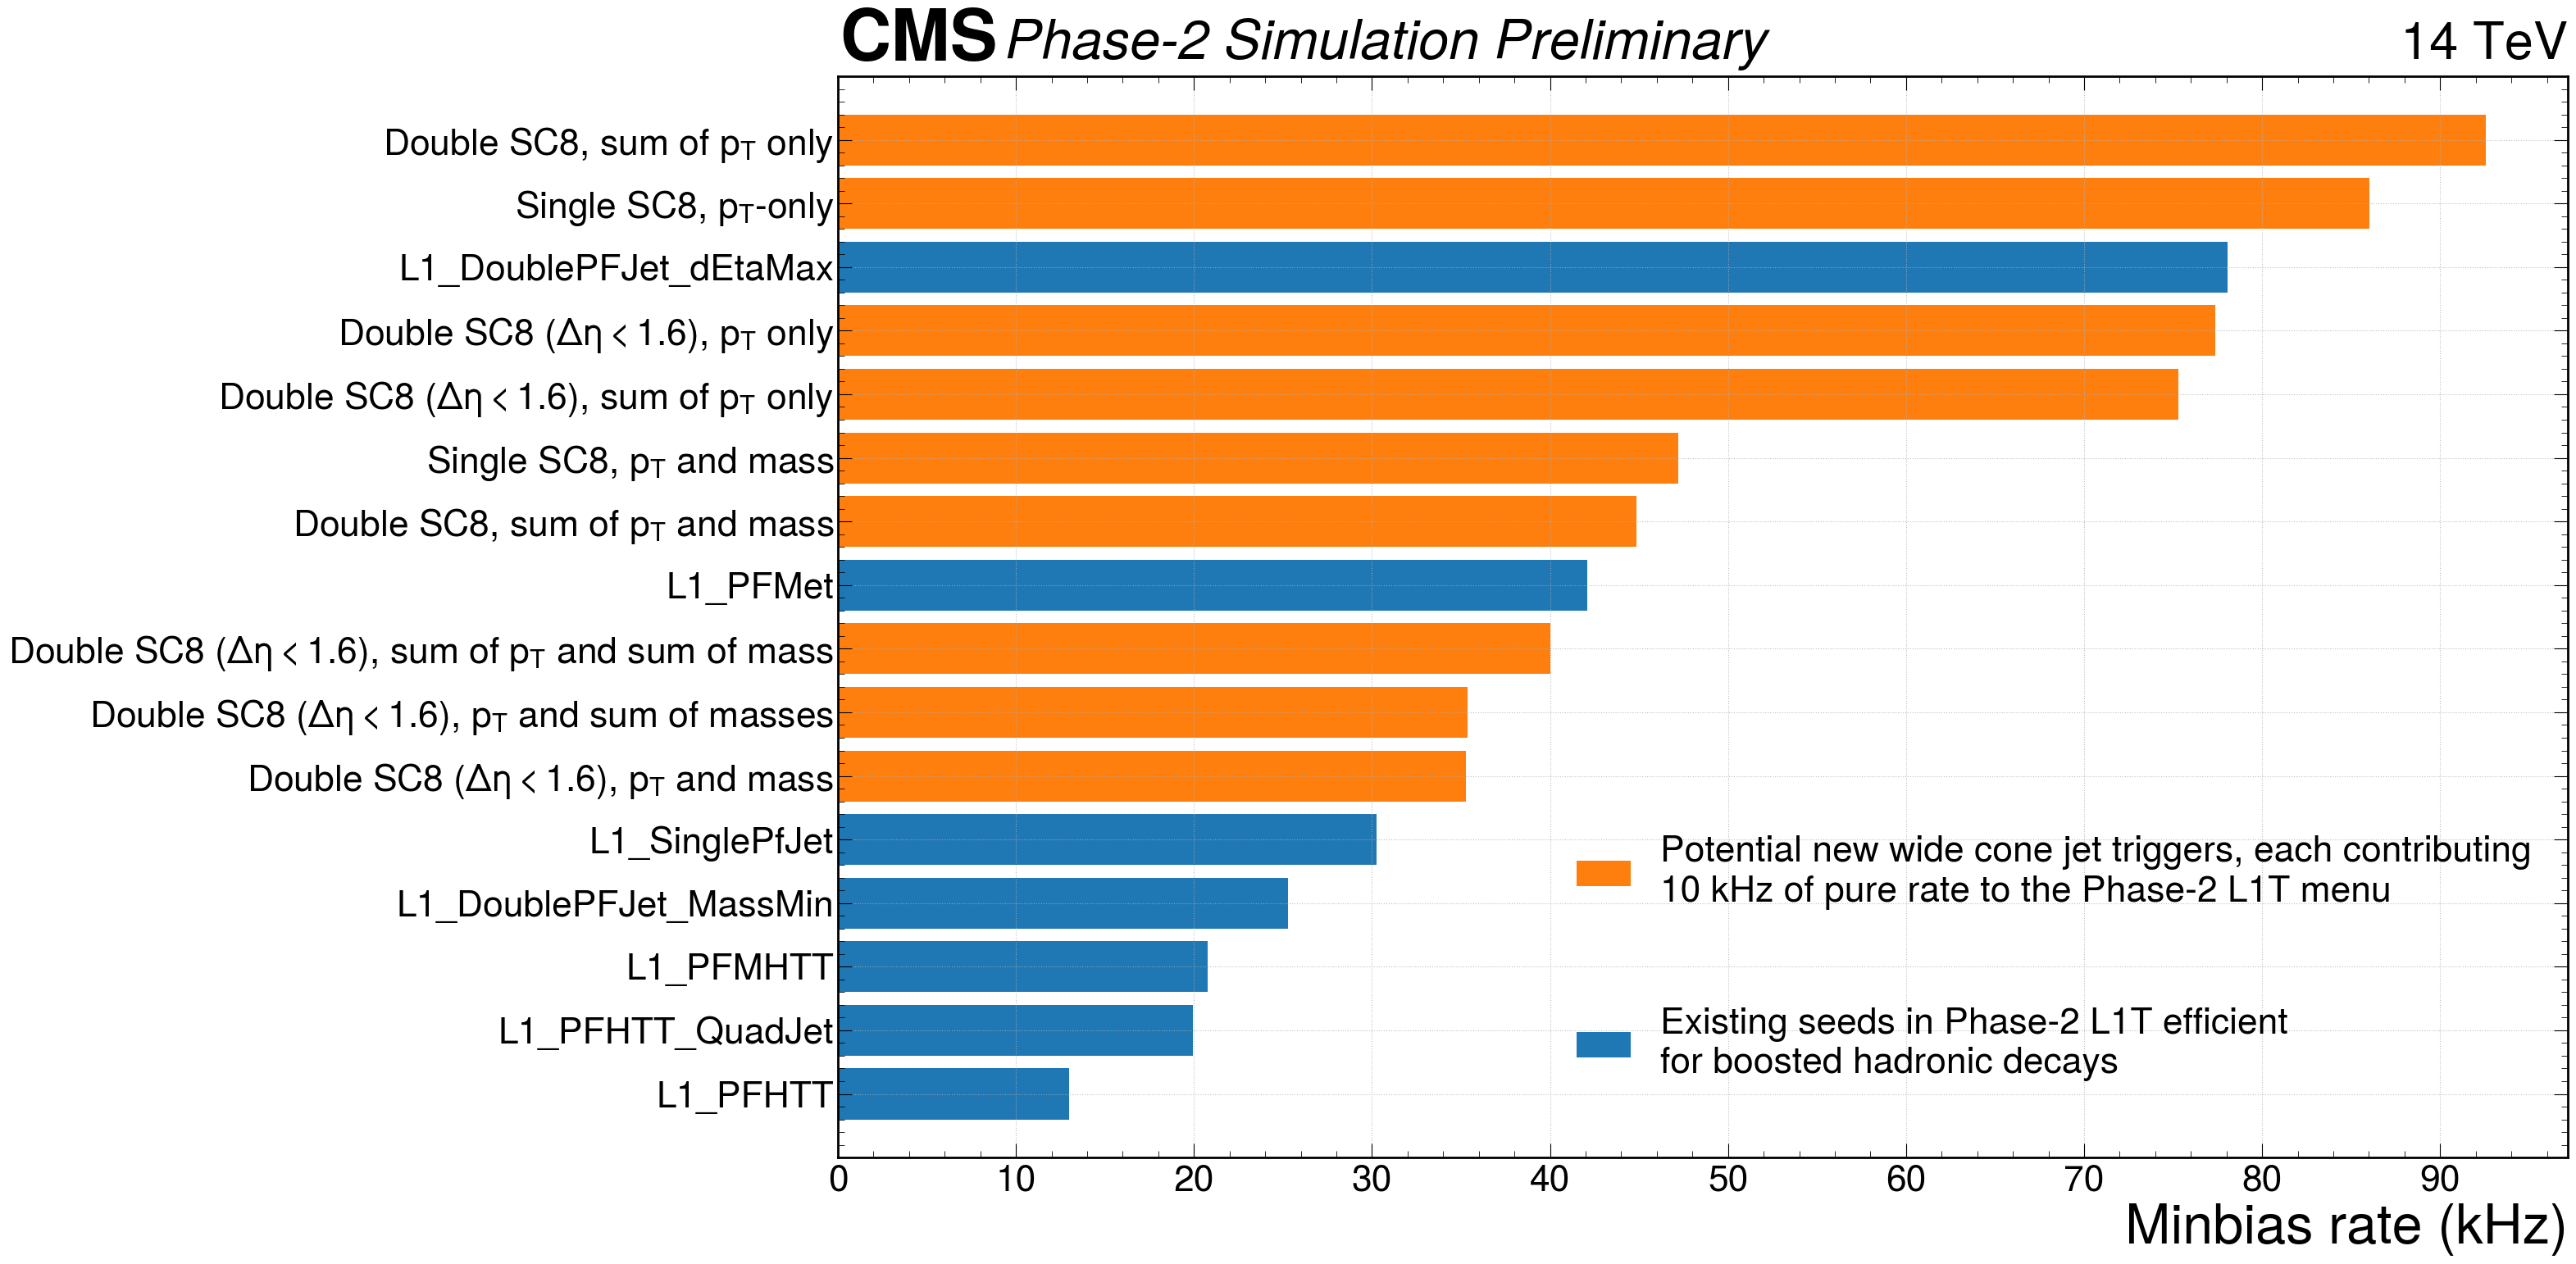

In [17]:
rates = append_rates(sig["LH30"], bkg, triggers)
plot_rates(rates, formatting)

In [18]:
tt = Signal(path_data="/eos/user/l/lroberts/Phase2-L1MenuTools/signal_samples/output_Phase2_L1T_signal.root", path_decisions="/eos/user/l/lroberts/Phase2-L1MenuTools/outputs/V49nano_AR25/rate_tables/TT_boosted_RateTable_V49nano_AR25_masks.parquet", exclude=exclude)

Loading sample from /eos/user/l/lroberts/Phase2-L1MenuTools/signal_samples/output_Phase2_L1T_signal.root with decisions from /eos/user/l/lroberts/Phase2-L1MenuTools/outputs/V49nano_AR25/rate_tables/TT_boosted_RateTable_V49nano_AR25_masks.parquet
    Loading trigger decision bits...
    Loading SC8 jets...


    Loading SC4 jets separated from leading SC8 jet...
    Signal sample with 57078 events


/tmp/lroberts/ipykernel_2007634/1357214223.py:15: UserWarning: WARNING: Mismatch! Number of events in jet data does not match number of events in decisions data.
  warnings.warn("WARNING: Mismatch! Number of events in jet data does not match number of events in decisions data.")


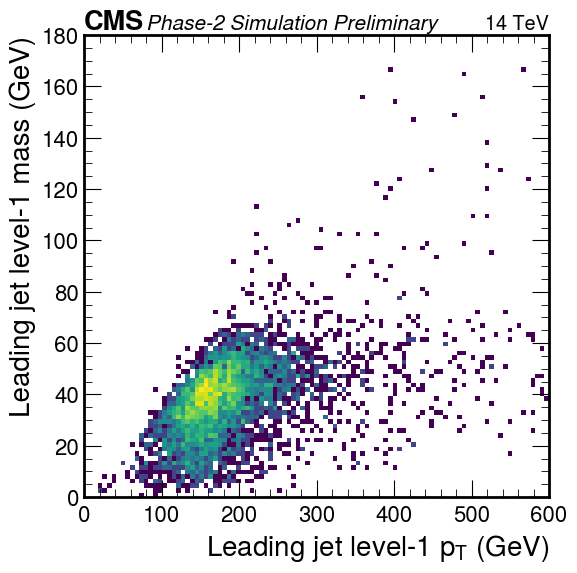

In [19]:
from typing import Union, Tuple, List, Optional
def plot_phase_space(sig: ak.Array, bins: Union[int, Tuple[int, int]] = (41, 41), pt_range: list = None, mass_range: list = None) -> None:
    # flatten awkward arrays

    sc8 = sig.sc8[(sig.sc8.pt > 0) & (sig.sc8.mass>0)]

    pt = ak.firsts(sc8.pt).to_numpy()
    mass = ak.firsts(sc8.mass).to_numpy()

    plt.figure(figsize=(6, 6), facecolor="white")
    # make the 2D histogram
    h = plt.hist2d(
        pt, 
        mass, 
        bins=bins, 
        range=[pt_range, mass_range], 
        cmap="viridis",
        norm=LogNorm()
    )
    
    # add labels and colorbar
    plt.xlabel("Leading jet level-1 $p_T$ (GeV)", fontsize=20)
    plt.ylabel("Leading jet level-1 mass (GeV)", fontsize=20)
    plt.xticks(np.linspace(pt_range[0], pt_range[-1], 7), fontsize=16)
    plt.yticks(np.linspace(mass_range[0], mass_range[-1], 10), fontsize=16)
    hep.cms.label(llabel="Phase-2 Simulation Preliminary", rlabel="14 TeV", fontsize=15)
    
    plt.show()
    
    return

plot_phase_space(sig["MX350_LH50"], bins=101, pt_range=[0, 600], mass_range=[0, 180])

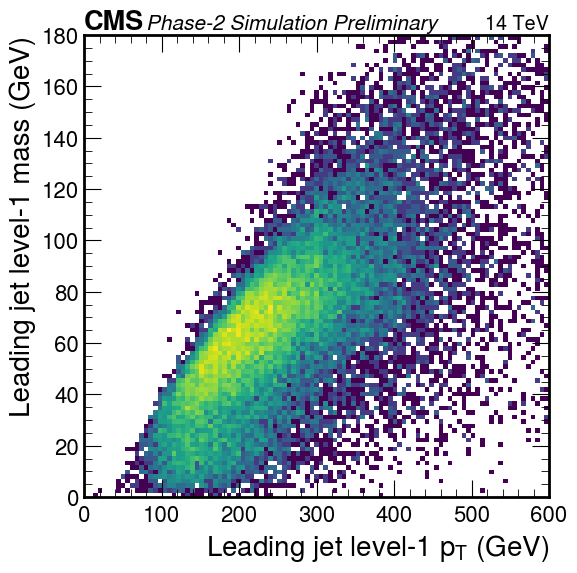

In [20]:
plot_phase_space(tt, bins=101, pt_range=[0, 600], mass_range=[0, 180])

In [21]:
def get_effs(sig, pt_trigger, mass_trigger):
    baseline_eff = sig.get_efficiency(mask = ak.zeros_like(ak.firsts(sig.sc8.pt), dtype=bool))
    pt_eff = sig.get_efficiency( seed = getattr(sig, pt_trigger) )
    mass_eff = sig.get_efficiency( seed = getattr(sig, mass_trigger) )

    return baseline_eff, pt_eff, mass_eff

In [22]:
get_effs(sig["LH30"], pt_trigger="L1_SinglePFJet8", mass_trigger = "L1_SinglePFJet8_Mass")

((np.float64(0.7167397660818714), np.float64(0.0)),
 (np.float64(0.7437865497076024), np.float64(0.027046783625730986)),
 (np.float64(0.7587719298245614), np.float64(0.04203216374269003)))

In [23]:
sig

{'MX350_LH50': <__main__.Signal at 0x7fedd128fe50>,
 'LH20': <__main__.Signal at 0x7fedcebaafa0>,
 'LH30': <__main__.Signal at 0x7fedd5890df0>,
 'LH40': <__main__.Signal at 0x7fedd1799790>,
 'LH50': <__main__.Signal at 0x7fed3767f8b0>,
 'LH60': <__main__.Signal at 0x7fedcec00fa0>,
 'LH70': <__main__.Signal at 0x7fedcec340a0>,
 'LH80': <__main__.Signal at 0x7fedcec342b0>,
 'LH90': <__main__.Signal at 0x7fedd14cfca0>}

In [24]:
vars(sig["LH30"].L1_DoublePFJet8_dEtaMax).values()

dict_values([86.74, 73.17, 1.6])

In [25]:
# Define your seeds
triggers = [
    "L1_SinglePFJet8",
    "L1_SinglePFJet8_Mass",
    "L1_DoublePFJet8_dEtaMax",
    "L1_DoublePFJet8_dEtaMax_Mass",
    "L1_DoublePFJet8_dEtaMax_Sum_Mass",
    "L1_DoublePFJet8_Sum",
    "L1_DoublePFJet8_Sum_Mass",
    "L1_DoublePFJet8_Sum_dEtaMax",
    "L1_DoublePFJet8_Sum_dEtaMax_Mass"
]

n_samples = len(sig)
n_trigs   = len(triggers)

eff_matrix = np.zeros((n_samples, n_trigs))
annot_matrix = np.empty((n_samples, n_trigs), dtype=object)

for i, (sname, s) in enumerate(sig.items()):
    for j, trig in enumerate(triggers):
        seed = getattr(s, trig)
        eff = s.get_efficiency(seed=seed)[-1] * 100
        rate = bkg.get_rate(
            mask=seed(bkg.sc8)
            )[0] / 1000  # convert Hz → kHz if needed

        try:
            thresholds = list(vars(seed).values())
            thr_str = ", ".join(str(t) for t in thresholds)
        except Exception:
            thr_str = "?"

        eff_matrix[i, j] = eff
        annot_matrix[i, j] = f"{thr_str}\n\n{eff:.2f}%\n\n{rate:.1f} kHz"

# Put efficiencies in dataframe (for coloring)
df = pd.DataFrame(
    eff_matrix,
    index=sig.keys(),
    columns=triggers
)

# Plot heatmap with custom annotations
plt.figure(figsize=(24, 24))
# sns.heatmap(df, annot=annot_matrix, fmt="", cmap="viridis", cbar_kws={'label': 'Efficiency increase (%)'}, annot_kws={"size": 10})
sns.heatmap(df, annot=annot_matrix, fmt="", cmap="viridis", annot_kws={"size": 12}, cbar=False)
# plt.title("Sample vs Menu Seed Efficiency Table")
plt.tight_layout()
plt.show()


NameError: name 'sns' is not defined

<Figure size 2400x2400 with 0 Axes>

In [35]:
df

,SinglePFJet8,SinglePFJet8_Mass,DoublePFJet8_dEtaMax,DoublePFJet8_dEtaMax_Mass,DoublePFJet8_dEtaMax_Sum_Mass,DoublePFJet8_Sum,DoublePFJet8_Sum_Mass,DoublePFJet8_Sum_dEtaMax,DoublePFJet8_Sum_dEtaMax_Mass
MX350_LH50,1.804018,2.439524,2.665027,2.644526,2.767528,2.460025,3.054531,2.870029,2.849528
LH20,1.175723,1.461710,2.923419,4.385129,3.558945,1.112170,2.129012,2.510327,3.336511
LH30,2.704678,4.203216,7.492690,8.662281,9.064327,3.472222,7.309942,7.017544,8.991228
LH40,2.357019,3.362218,4.575390,4.506066,4.679376,3.847487,4.956672,4.575390,5.025997
LH50,0.914495,1.188843,1.051669,0.914495,0.914495,1.234568,1.417467,1.005944,1.005944
LH60,0.480591,0.517560,0.369686,0.295749,0.369686,0.554529,0.628466,0.406654,0.406654
LH70,0.210843,0.271084,0.120482,0.120482,0.150602,0.240964,0.331325,0.150602,0.150602
LH80,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LH90,0.000000,0.000000,0.000000,0.000000,0.000000,0.035791,0.035791,0.000000,0.000000


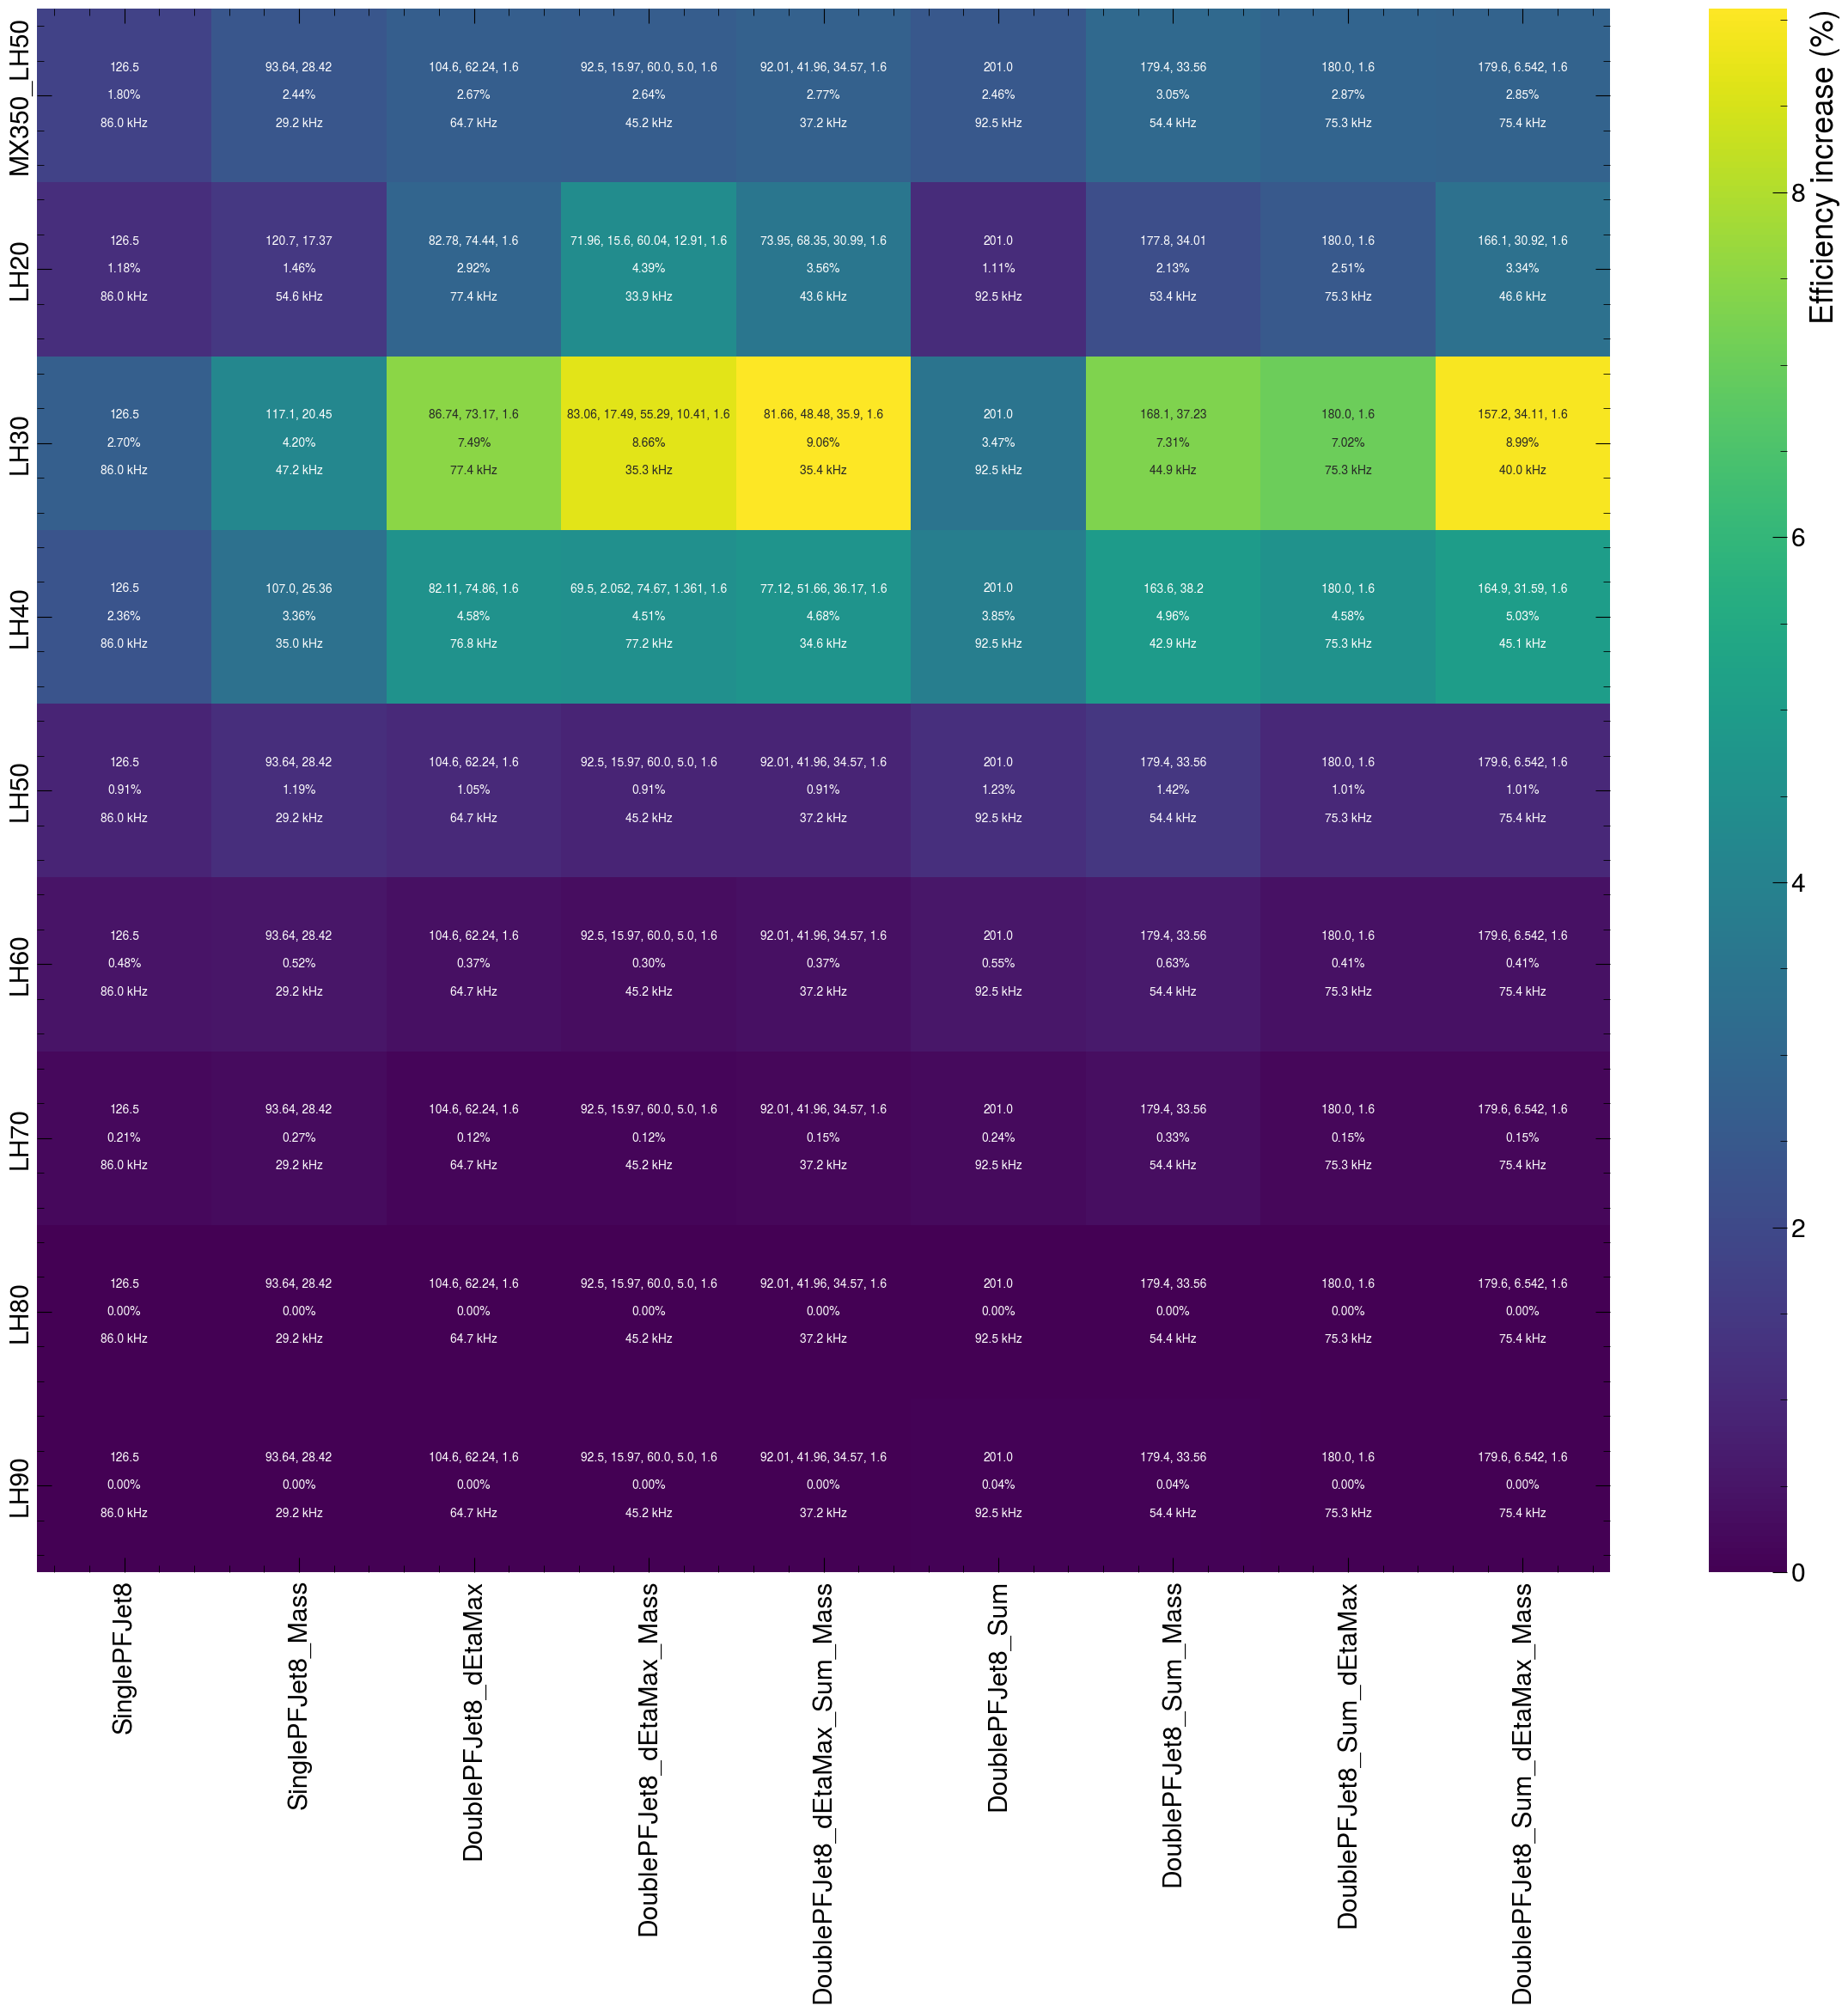

In [34]:
import seaborn as sns
#Define your seeds
triggers = [ "L1_SinglePFJet8", "L1_SinglePFJet8_Mass", "L1_DoublePFJet8_dEtaMax", "L1_DoublePFJet8_dEtaMax_Mass", "L1_DoublePFJet8_dEtaMax_Sum_Mass", "L1_DoublePFJet8_Sum", "L1_DoublePFJet8_Sum_Mass", "L1_DoublePFJet8_Sum_dEtaMax", "L1_DoublePFJet8_Sum_dEtaMax_Mass" ]
n_samples = len(sig)
n_trigs = len(triggers)
eff_matrix = np.zeros((n_samples, n_trigs))
annot_matrix = np.empty((n_samples, n_trigs), dtype=object)
for i, (sname, s) in enumerate(sig.items()):
    for j, trig in enumerate(triggers):
        seed = getattr(s, trig)
        eff = s.get_efficiency(seed=seed)[-1] * 100
        rate = bkg.get_rate( mask=seed(bkg.sc8) )[0] / 1000 # convert Hz → kHz if needed
        try: 
            thresholds = list(vars(seed).values())
            thr_str = ", ".join(str(t) for t in thresholds)
        except Exception: 
            thr_str = "?"
        
        eff_matrix[i, j] = eff
        annot_matrix[i, j] = f"{thr_str}\n\n{eff:.2f}%\n\n{rate:.1f} kHz"
            # Put efficiencies in dataframe (for coloring)

triggers = [t.split("_", maxsplit=1)[-1] for t in triggers]
df = pd.DataFrame( eff_matrix, index=sig.keys(), columns=triggers ) # Plot heatmap with custom annotations
plt.figure(figsize=(24, 24))
sns.heatmap(df, annot=annot_matrix, fmt="", cmap="viridis", cbar_kws={'label': 'Efficiency increase (%)'}, annot_kws={"size": 10})
# sns.heatmap(df, annot=annot_matrix, fmt="", cmap="viridis", annot_kws={"size": 10}) # plt.title("Sample vs Menu Seed Efficiency Table")
plt.tight_layout()
plt.show()

In [ ]:
from typing import Union, Tuple, List, Optional
class Plots:

    @staticmethod
    def plot_phase_space(sig: ak.Array, bins: Union[int, Tuple[int, int]] = (41, 41), pt_range: list = None, mass_range: list = None) -> None:
        # flatten awkward arrays

        sc8 = sig.sc8[(sig.sc8.pt > 0) & (sig.sc8.mass>0)]

        pt = ak.firsts(sc8.pt).to_numpy()
        mass = ak.firsts(sc8.mass).to_numpy()

        plt.figure(figsize=(6, 6), facecolor="white")
        # make the 2D histogram
        h = plt.hist2d(
            pt, 
            mass, 
            bins=bins, 
            range=[pt_range, mass_range], 
            cmap="viridis",
            norm=LogNorm()
        )
        
        # add labels and colorbar
        plt.xlabel("Leading jet level-1 $p_T$ (GeV)", fontsize=20)
        plt.ylabel("Leading jet level-1 mass (GeV)", fontsize=20)
        plt.xticks(np.linspace(pt_range[0], pt_range[-1], 7), fontsize=16)
        plt.yticks(np.linspace(mass_range[0], mass_range[-1], 10), fontsize=16)
        hep.cms.label(llabel="Phase-2 Simulation Preliminary", rlabel="14 TeV", fontsize=15)
        
        plt.show()
        
        return
    
    @staticmethod
    def plot_eff_matrix():
        import seaborn as sns

        # Define your seeds
        triggers = [
            "L1_SinglePFJet8",
            "L1_SinglePFJet8_Mass",
            "L1_DoublePFJet8_dEtaMax",
            "L1_DoublePFJet8_dEtaMax_Mass",
            "L1_DoublePFJet8_dEtaMax_Sum_Mass",
            "L1_DoublePFJet8_Sum",
            "L1_DoublePFJet8_Sum_Mass",
            "L1_DoublePFJet8_Sum_dEtaMax",
            "L1_DoublePFJet8_Sum_dEtaMax_Mass"
        ]  # keeping 8 seeds for 8x8 table

        # Build efficiency matrix
        eff_matrix = np.zeros((len(sig), len(triggers)))

        for i, s in enumerate(sig.values()):  # take 8 samples
            for j, trig in enumerate(triggers):
                eff_matrix[i, j] = s.get_efficiency(seed=getattr(s, trig))[-1]*100

        # Convert to dataframe for nice labels
        df = pd.DataFrame(
            eff_matrix,
            index = sig.keys(),
            # index=[f"Sample {i+1}" for i in range(9)],  # or use s.name if available
            columns=triggers
        )

        # Plot heatmap
        plt.figure(figsize=(18, 18))
        sns.heatmap(df, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Efficiency'})
        plt.title("Sample vs Menu Seed Efficiency Table")
        # plt.xlabel("Menu Seed")
        # plt.ylabel("Sample")
        plt.tight_layout()
        plt.show()
        
        return


In [ ]:
def get_bar_plot(seed):
    """ SINGLE PF JET8 """
    ys = []
    xs_baseline = []
    xs_pt = []
    xs_mass = []
    for sig_name, s in sig.items():
        ptonly_seed = getattr(s, seed)  # ensure the trigger is defined
        ptandmass_seed = getattr(s, seed+"_Mass")
        baseline_mask = ak.zeros_like(ptonly_seed(s.sc8), dtype=bool)
        x_baseline = s.get_efficiency(mask = baseline_mask)[0]
        x_pt = s.get_efficiency(seed = ptonly_seed)[0]
        x_mass = s.get_efficiency(seed = ptandmass_seed)[0]

        xs_baseline.append(x_baseline)
        xs_pt.append(x_pt)
        xs_mass.append(x_mass)
        ys.append(sig_name)

    return xs_baseline, xs_pt, xs_mass, ys

In [ ]:
def get_bar_plot(seeds):
    """
    seeds: list of 4 seed names
    """
    ys = []
    results = {seed: {"baseline": [], "pt": [], "mass": []} for seed in seeds}

    for sig_name, s in sig.items():
        for seed in seeds:
            ptonly_seed = getattr(s, seed)
            ptandmass_seed = getattr(s, seed + "_Mass")
            baseline_mask = ak.zeros_like(ptonly_seed(s.sc8), dtype=bool)

            x_baseline = s.get_efficiency(mask=baseline_mask)[0]
            x_pt = s.get_efficiency(seed=ptonly_seed)[0]
            x_mass = s.get_efficiency(seed=ptandmass_seed)[0]

            results[seed]["baseline"].append(x_baseline)
            results[seed]["pt"].append(x_pt)
            results[seed]["mass"].append(x_mass)

        ys.append(sig_name)

    return { k: {kk : np.array(vv) for kk, vv in v.items()} for k, v in results.items() }, ys


In [ ]:
seeds = ["L1_SinglePFJet8", "L1_DoublePFJet8_dEtaMax", "L1_DoublePFJet8_Sum", "L1_DoublePFJet8_Sum_dEtaMax"]
results, ys = get_bar_plot(seeds)

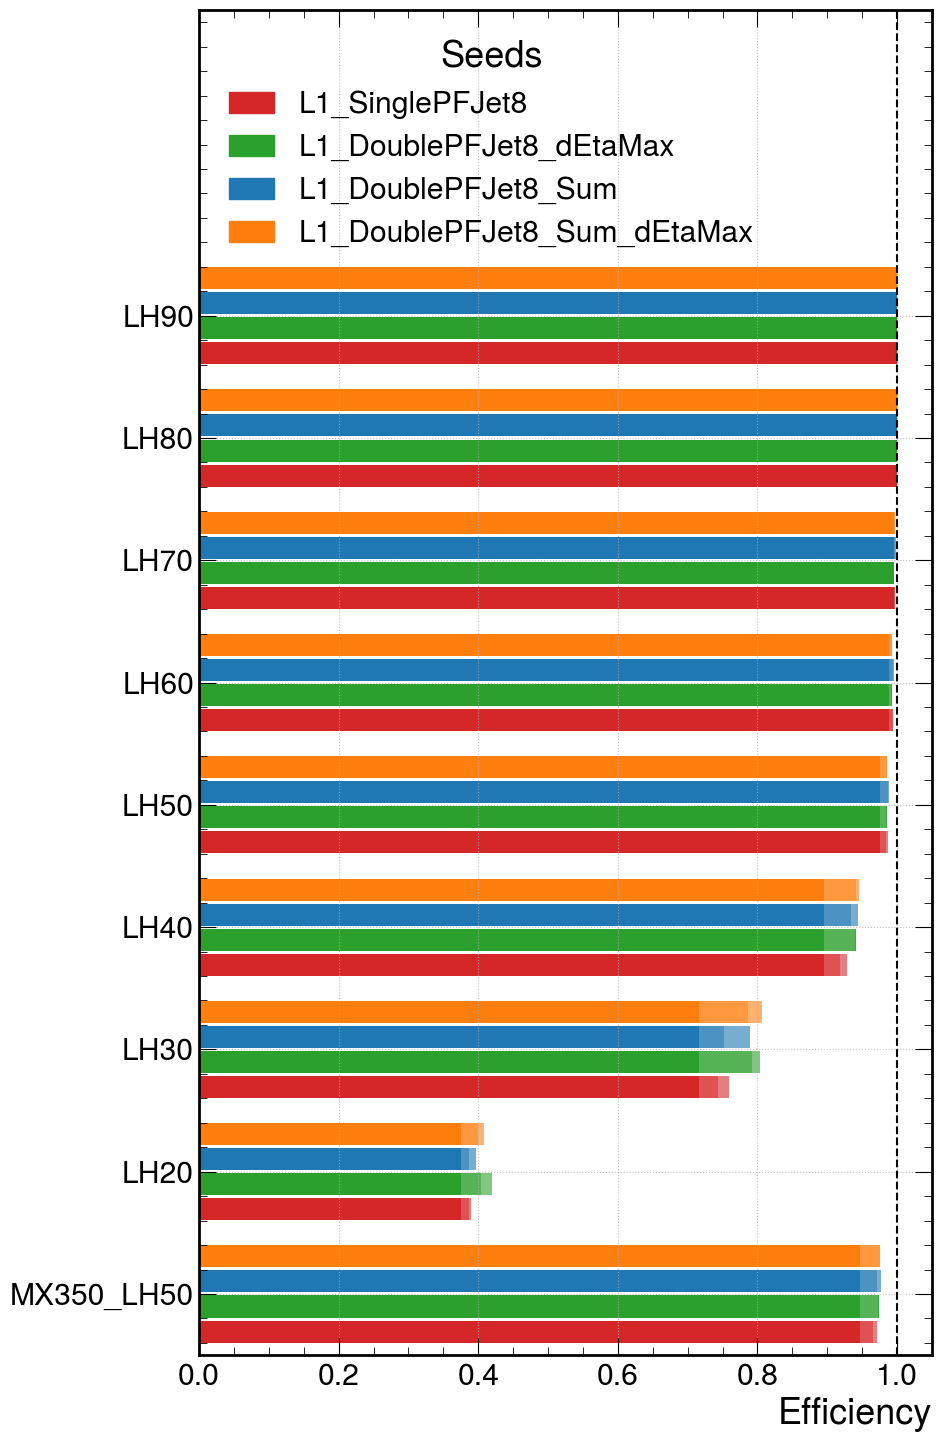

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 15))

bar_height = 0.18
gap = 0.025  # small vertical gap between stacked bars
group_width = len(seeds) * (bar_height + gap)

y_positions = np.arange(len(ys))

colours = ["tab:red", "tab:green", "tab:blue", "tab:orange"]
seed_colours = iter(colours)

for i, seed in enumerate(seeds):
    offset = (i - (len(seeds)-1)/2) * (bar_height + gap)  # centers group around tick
    col = next(seed_colours)
    baseline = np.array(results[seed]["baseline"])
    pt = np.array(results[seed]["pt"]) - baseline
    mass = np.array(results[seed]["mass"]) - np.array(results[seed]["pt"])

    ax.barh(y_positions + offset, baseline, height=bar_height, color=col, label="Baseline" if i == 0 else "", alpha=1.0)
    ax.barh(y_positions + offset, pt, left=baseline, height=bar_height, color=col, label="Baseline+pt" if i == 0 else "", alpha=0.8)
    ax.barh(y_positions + offset, mass, left=baseline+pt, height=bar_height, color=col, label="Baseline+pt+mass" if i == 0 else "", alpha=0.6)

plt.axvline(1.0, color='black', linestyle='--', label='100% Efficiency')

ax.set_yticks(y_positions)
ax.set_yticklabels(ys)
ax.set_xlabel("Efficiency")
ax.set_xlim([0, 1.05])
ax.set_ylim([-0.5, len(ys)+1.5])
plt.grid()
plt.tight_layout()

# First legend: stack meaning
# stack_legend = ax.legend(loc="upper left", title="Stack meaning")

# Second legend: seed colours
seed_patches = [mpatches.Patch(color=c, label=s) for s, c in zip(seeds, colours)]
seed_legend = ax.legend(handles=seed_patches, loc="upper left", title="Seeds")

# Add both legends
# ax.add_artist(stack_legend)

plt.show()


In [ ]:
gain_results = {}
for k, v in results.items():
    ptonly_gain = v["pt"] - v["baseline"]
    ptandmass_gain = v["mass"] - v["baseline"]
    gain_results[k] = {"pt": ptonly_gain, "mass": ptandmass_gain}

In [ ]:
def plot_diff(seed_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # seed_name = "L1_SinglePFJet8"  # or any other seed you want to plot
    pt_gain = gain_results[seed_name]["pt"]*100
    mass_gain = gain_results[seed_name]["mass"]*100

    bar_height = 0.35
    indices = np.arange(len(ys))

    ax.barh(indices - bar_height/2, pt_gain, height=bar_height, label="Using pT only", color="tab:blue")
    ax.barh(indices + bar_height/2, mass_gain, height=bar_height, label="Using pT and mass", color="tab:orange")

    ax.set_yticks(indices)
    ax.set_yticklabels(ys, rotation=0, ha="right")
    ax.set_xlabel("Efficiency increase (%)")
    ax.set_title(f"Efficiency increase for {seed_name}")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    return

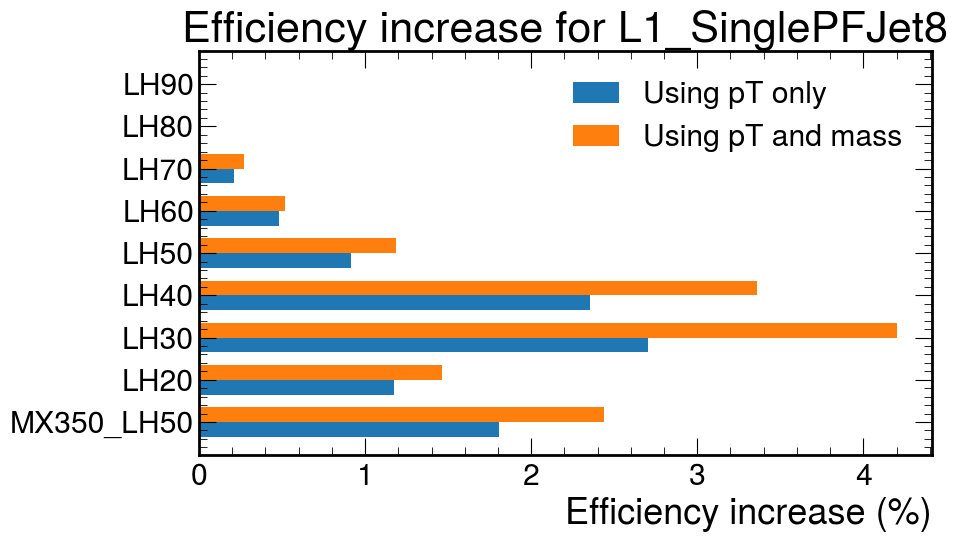

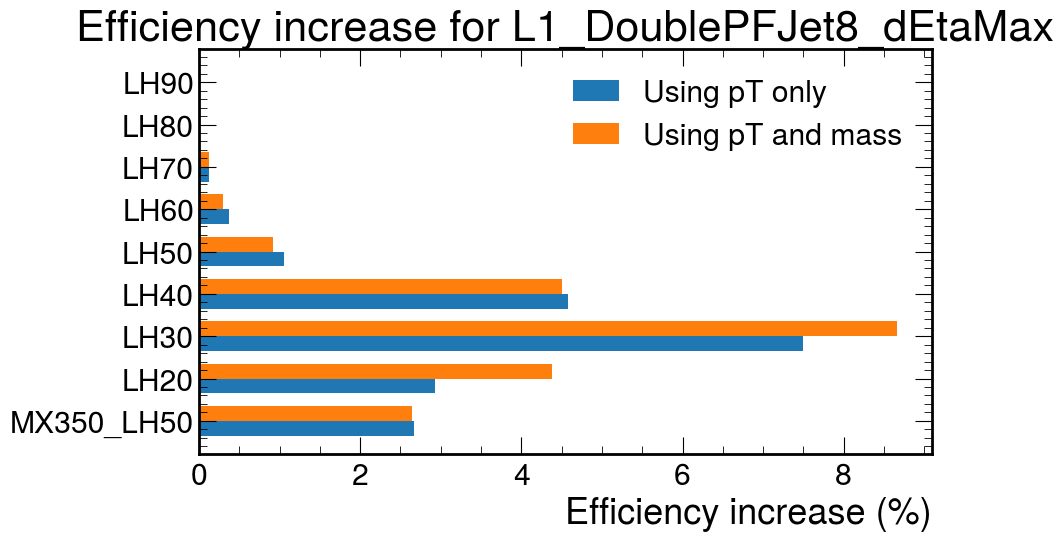

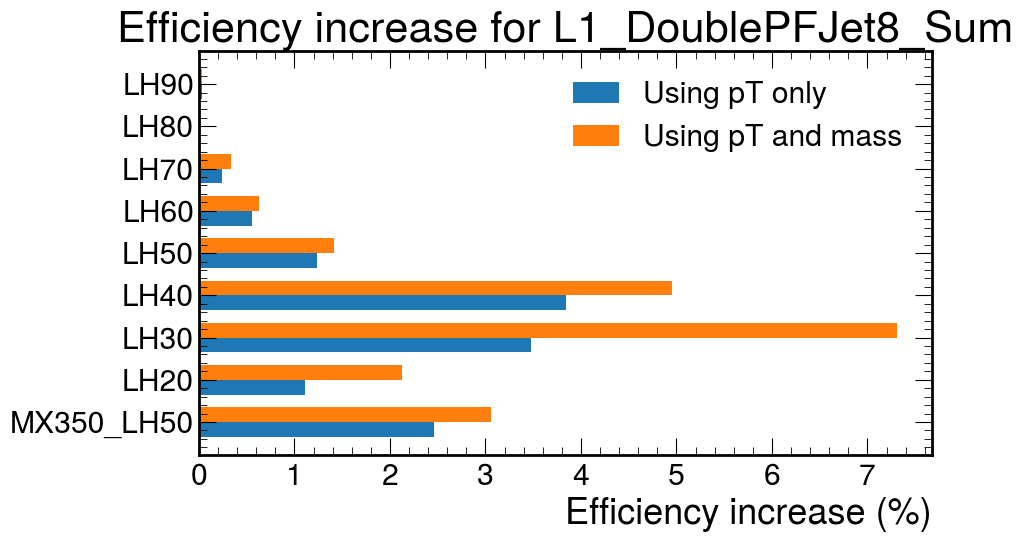

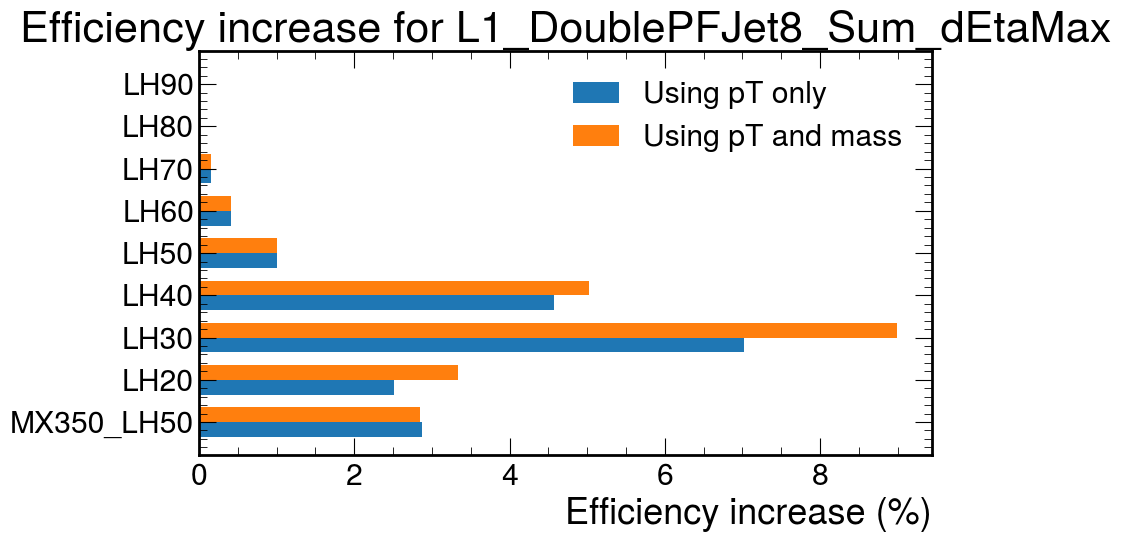

In [ ]:
plot_diff("L1_SinglePFJet8")
plot_diff("L1_DoublePFJet8_dEtaMax")
plot_diff("L1_DoublePFJet8_Sum")
plot_diff("L1_DoublePFJet8_Sum_dEtaMax")


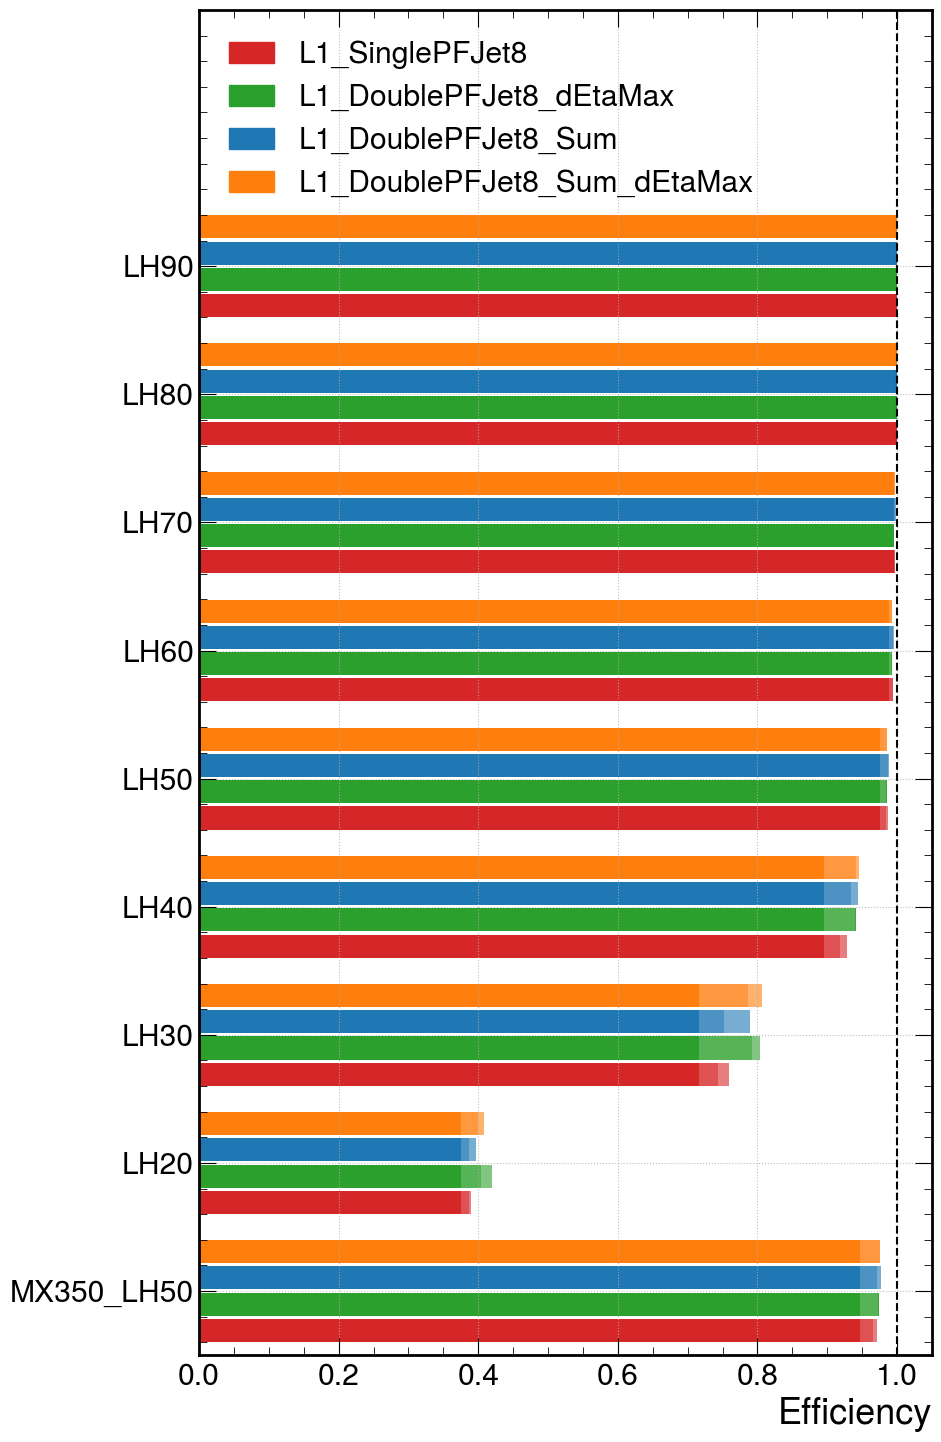

In [ ]:
# import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 15))

bar_height = 0.18
gap = 0.025  # small vertical gap between stacked bars
group_width = len(seeds) * (bar_height + gap)

y_positions = np.arange(len(ys))

colours = ["tab:red", "tab:green", "tab:blue", "tab:orange"]
seed_colours = iter(colours)

for i, seed in enumerate(seeds):
    offset = (i - (len(seeds)-1)/2) * (bar_height + gap)  # centers group around tick
    col = next(seed_colours)
    baseline = np.array(results[seed]["baseline"])
    pt = np.array(results[seed]["pt"]) - baseline
    mass = np.array(results[seed]["mass"]) - np.array(results[seed]["pt"])

    ax.barh(y_positions + offset, baseline, height=bar_height, color=col, label="Baseline" if i == 0 else "", alpha=1.0)
    ax.barh(y_positions + offset, pt, left=baseline, height=bar_height, color=col, label="Baseline+pt" if i == 0 else "", alpha=0.8)
    ax.barh(y_positions + offset, mass, left=baseline+pt, height=bar_height, color=col, label="Baseline+pt+mass" if i == 0 else "", alpha=0.6)

plt.axvline(1.0, color='black', linestyle='--', label='100% Efficiency')

ax.set_yticks(y_positions)
ax.set_yticklabels(ys)
ax.set_xlabel("Efficiency")
ax.set_xlim([0, 1.05])
ax.set_ylim([-0.5, len(ys)+1])
plt.grid()
plt.tight_layout()

# First legend: stack meaning
# stack_legend = ax.legend(loc="upper left", title="Stack meaning")

# Second legend: seed colours
seed_patches = [mpatches.Patch(color=c, label=s) for s, c in zip(seeds, colours)]
seed_legend = ax.legend(handles=seed_patches, loc="upper left")

# Add both legends
# ax.add_artist(stack_legend)

plt.show()


In [ ]:
K*(np.sum( bkg.decisions.any(axis=1) / len(bkg.decisions) ))

np.float64(574664.3790938086)

In [ ]:
relevant_seeds = ["L1_DoublePFJet_MassMin", "L1_DoublePFJet_dEtaMax", "L1_PFHTT", "L1_PFHTT_QuadJet", "L1_PFMHTT", "L1_PFMet", "L1_SinglePfJet"]

In [ ]:
bkg_rates[relevant_seeds]

NameError: name 'bkg_rates' is not defined

In [ ]:
sig["LH30"].L1_DoublePFJet8_Sum_Mass

In [ ]:
msk1 = sig["LH20"].L1_DoublePFJet8_Sum_Mass(bkg.sc8)
msk2 = sig["LH30"].L1_DoublePFJet8_Sum_Mass(bkg.sc8)
msk3 = sig["LH40"].L1_DoublePFJet8_Sum_Mass(bkg.sc8)

In [ ]:
bkg.get_rate(msk1)

(np.float64(53419.285151016884), np.float64(9988.717446174904))

In [ ]:
bkg.get_rate(msk2)

NameError: name 'msk2' is not defined

In [ ]:
bkg.get_rate(msk3)

(np.float64(42913.9099059019), np.float64(9957.404852299747))

In [ ]:
def plot_rate(seeds=None):
    bkg_rates = K * (bkg.decisions.sum(axis=0) / bkg.decisions.count(axis=0))
    if seeds == None:
        seeds=bkg_rates.index
    bkg_rates = bkg_rates[seeds]
    bkg_rates_sorted = bkg_rates.sort_values(ascending=True)

    ys = list(bkg_rates_sorted.index)
    ys = [s.split("_", maxsplit=1)[-1] for s in ys]

    plt.figure(figsize=(12, len(seeds)), facecolor="white")
    plt.barh(ys, bkg_rates_sorted.values/1000, label=f"Total rate = { np.round( K*(np.sum( bkg.decisions.any(axis=1) / len(bkg.decisions) ))/1000, 2) } kHz")
    plt.ylim([-1, len(bkg_rates_sorted.index)])
    plt.xlabel("Minbias rate (kHz)")
    plt.grid(axis="y")
    plt.legend(loc="center right", fontsize=24)
    hep.cms.label(llabel="Phase-2 Simulation Preliminary", rlabel="14 TeV")
    plt.show()

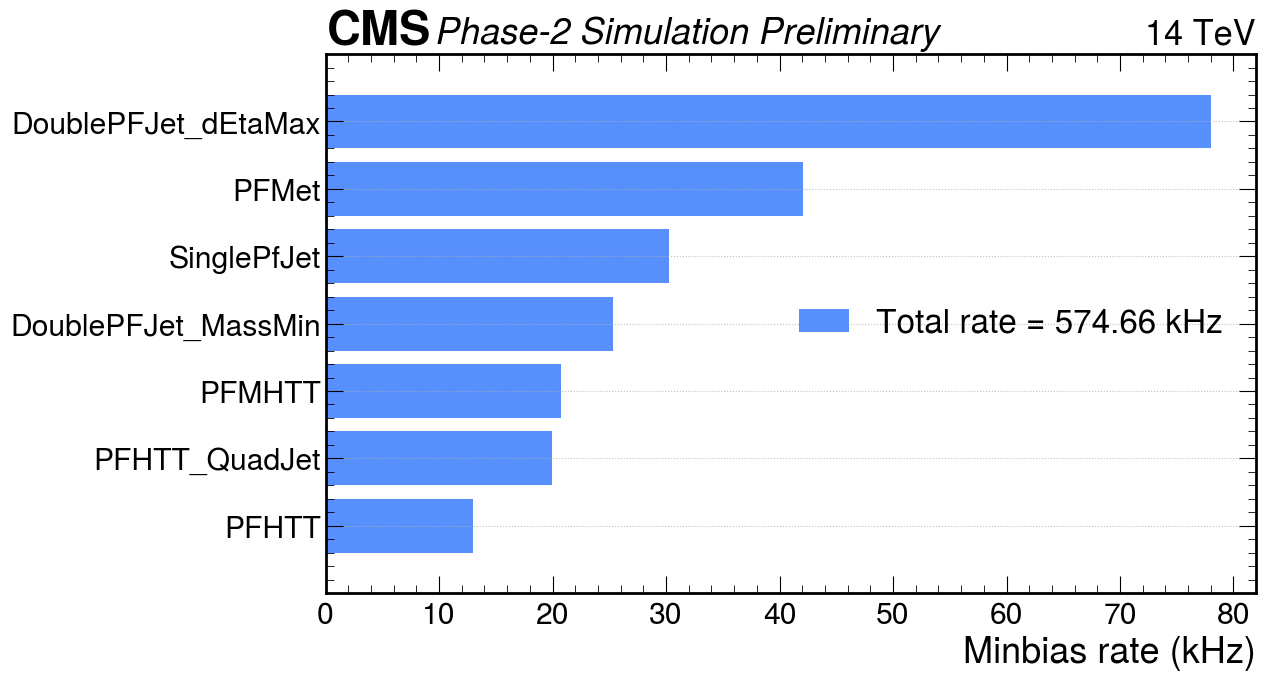

In [ ]:
plot_rate(relevant_seeds)

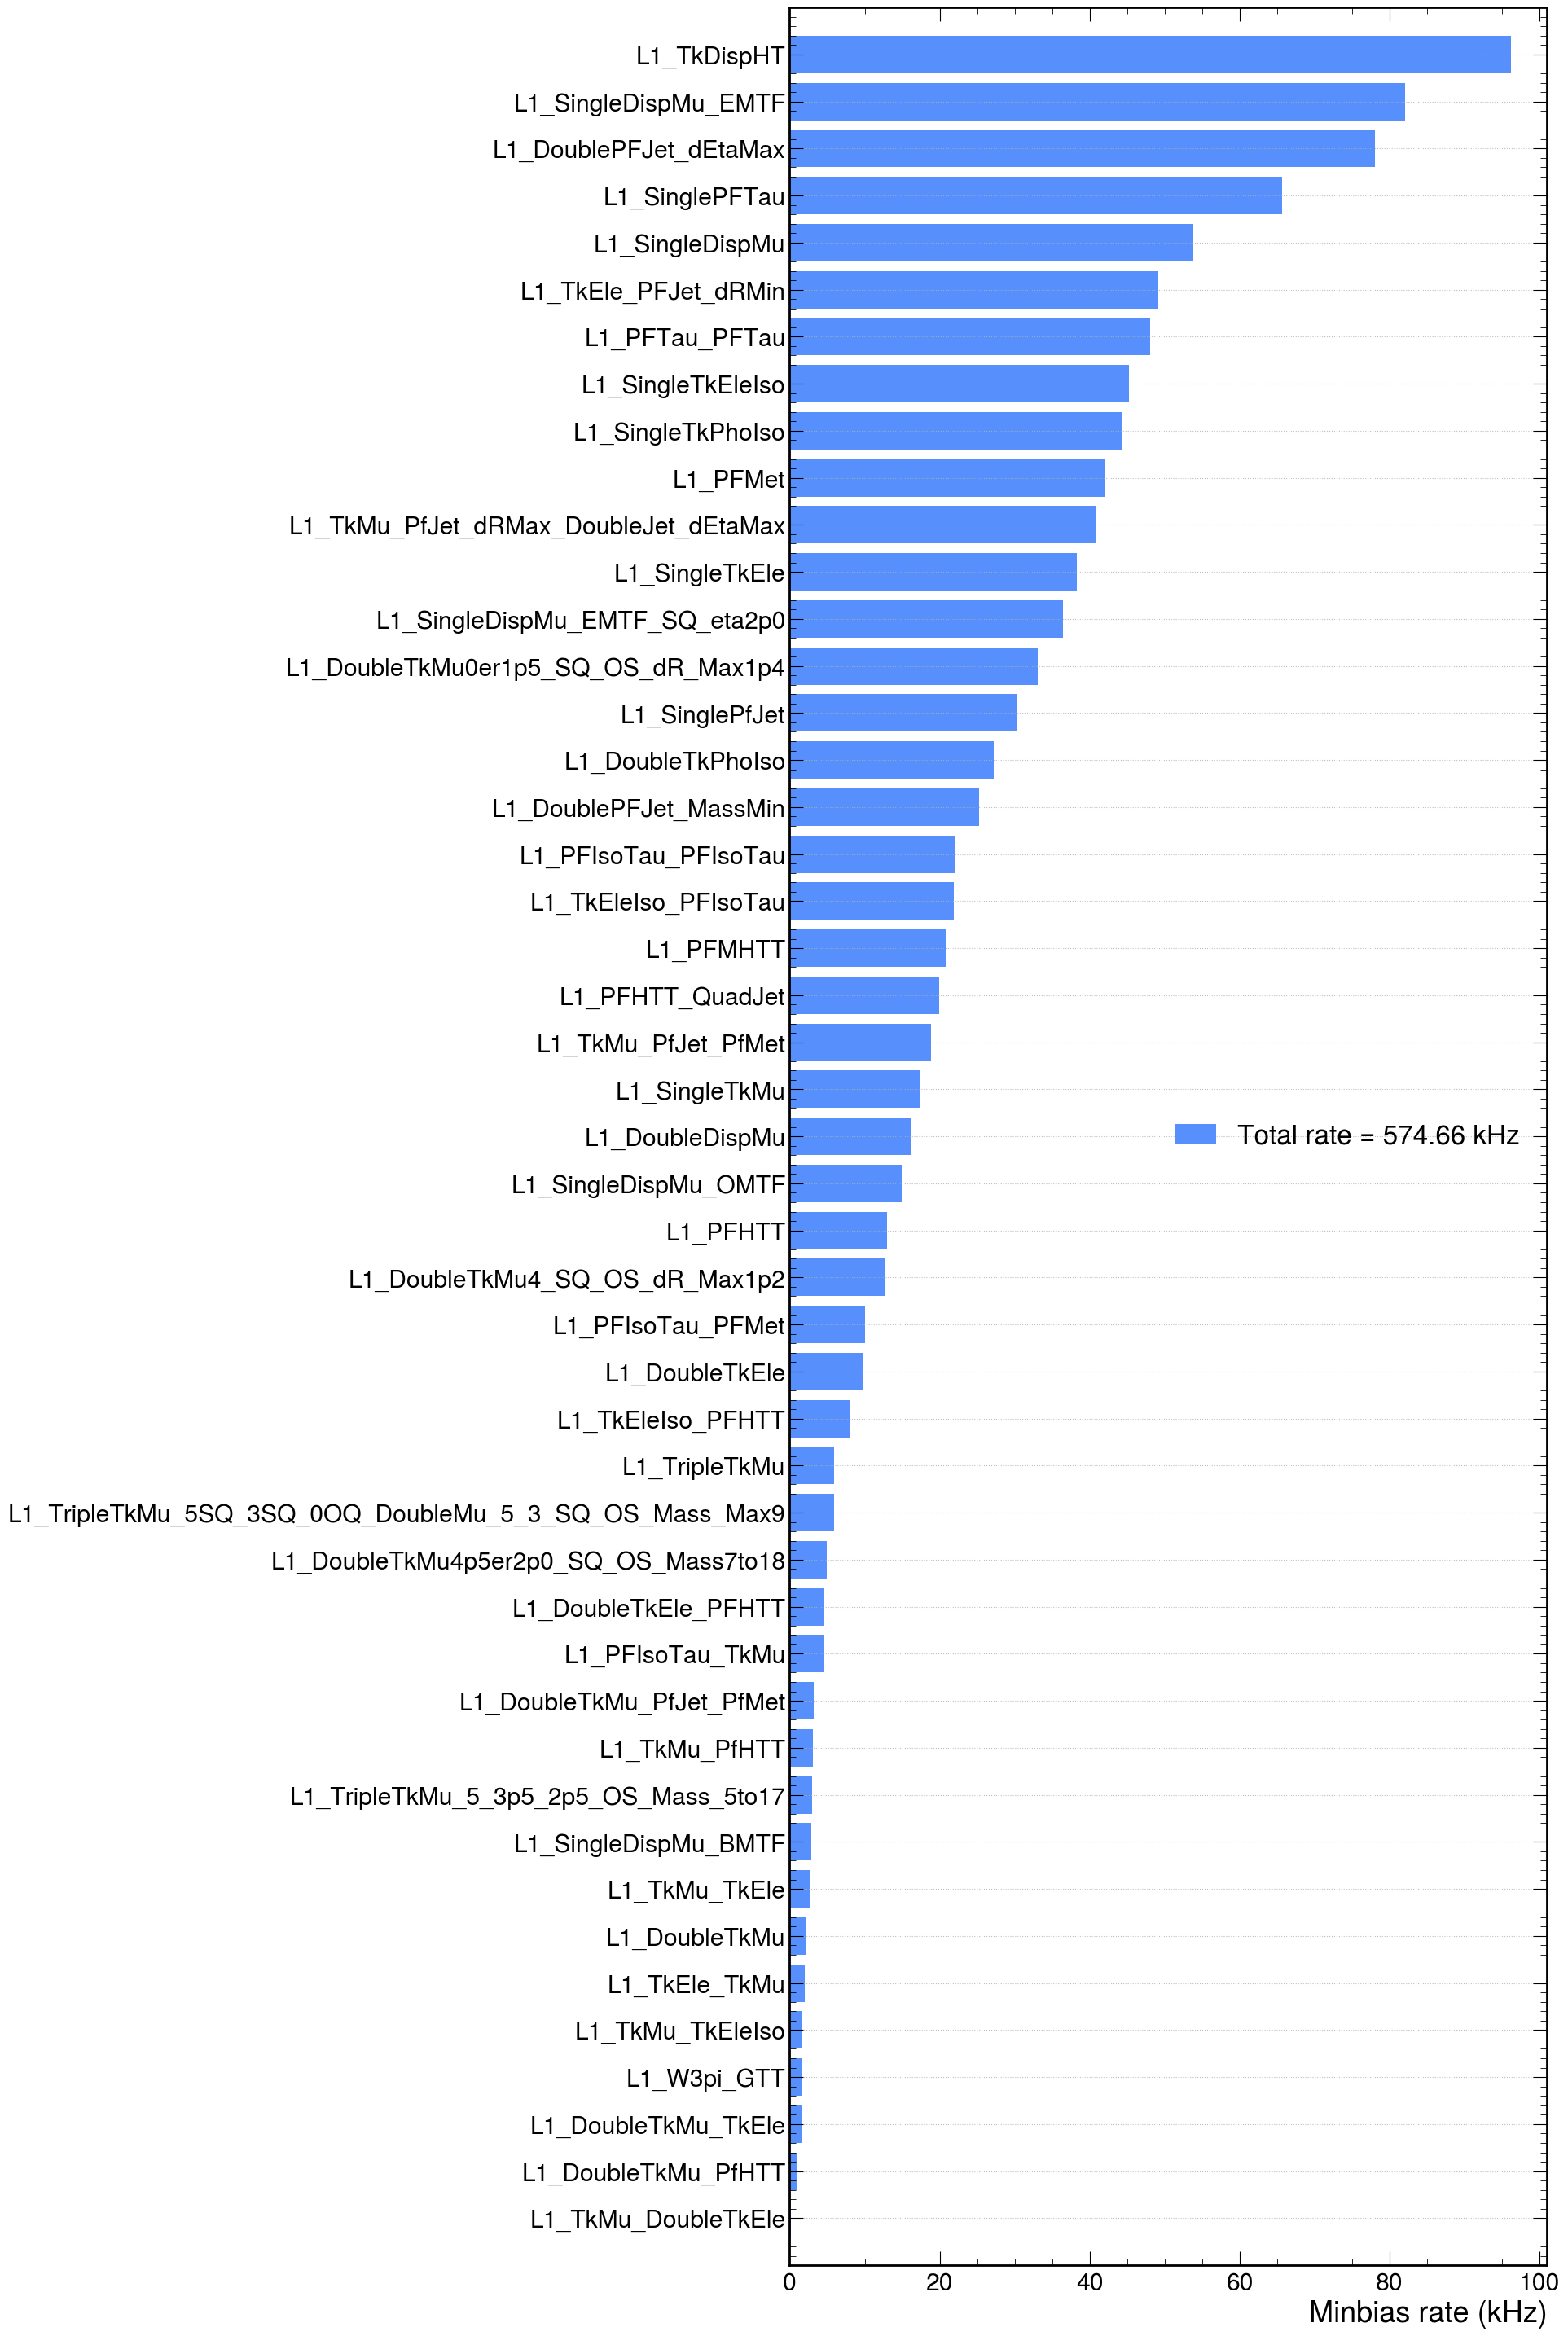

In [ ]:
bkg_rates = K * (bkg.decisions.sum(axis=0) / bkg.decisions.count(axis=0))
bkg_rates_sorted = bkg_rates.sort_values(ascending=True)
plt.figure(figsize=(12, 36), facecolor="white")
plt.barh(bkg_rates_sorted.index, bkg_rates_sorted.values/1000, label=f"Total rate = { np.round( K*(np.sum( bkg.decisions.any(axis=1) / len(bkg.decisions) ))/1000, 2) } kHz")
plt.ylim([-1, len(bkg_rates_sorted.index)])
plt.xlabel("Minbias rate (kHz)")
plt.grid(axis="y")
plt.legend(loc="center right", fontsize=24)
plt.show()